In [4]:
import numpy as np
import time
from tqdm import tqdm

import torch.nn as nn
import torch
import os

import torchvision
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.models import vgg19,VGG19_Weights

In [5]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

from torch.utils.data import Dataset, TensorDataset, dataloader, RandomSampler, DataLoader

In [6]:
!nvidia-smi

Fri Jun 30 18:55:33 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8               9W /  30W |    472MiB /  4096MiB |     23%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# getting the images :

def load_image(path='some path',style_no = None, size = (224,224)):
    
    # basic transforms required to pass the image to vgg19 model
    image_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0, 0, 0],std=[255, 255, 255]),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

    if style_no != None :
        style_path = f"style images/style{style_no}.jpg"
        image = Image.open(style_path).convert('RGB') 
        style_image = image_transforms(image).to(device)
        return style_image

    else :
        content_path = path
        image = Image.open(content_path).convert('RGB') 
        # print(np.array(image.convert('RGB')).max())
        content_image = image_transforms(image).to(device)
        return content_image


### Segmentation model

In [1]:
from transformers import AutoFeatureExtractor, SegformerForSemanticSegmentation

extractor = AutoFeatureExtractor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")


C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
C:\Users\pcdpm\AppData\Roaming\Python\Python310\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


Downloading:   0%|          | 0.00/110M [00:00<?, ?B/s]

c:\Python310\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pcdpm\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
image = Image.open(f'Celeb-images\wednesday-thinking.jfif').convert('RGB') 

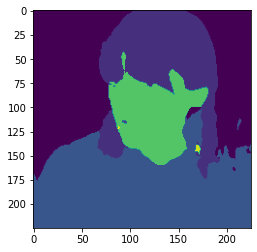

In [11]:
image = Image.open(f'Celeb-images\wednesday-thinking.jfif').convert('RGB') 
inputs = extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

In [12]:
seg_config = SegformerForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes").config

In [13]:
seg_config.label2id

{'Background': 0,
 'Bag': 16,
 'Belt': 8,
 'Dress': 7,
 'Face': 11,
 'Hair': 2,
 'Hat': 1,
 'Left-arm': 14,
 'Left-leg': 12,
 'Left-shoe': 9,
 'Pants': 6,
 'Right-arm': 15,
 'Right-leg': 13,
 'Right-shoe': 10,
 'Scarf': 17,
 'Skirt': 5,
 'Sunglasses': 3,
 'Upper-clothes': 4}

In [14]:
logits.shape

torch.Size([1, 18, 128, 128])

In [16]:
upsampled_logits.shape

torch.Size([1, 18, 225, 225])

In [17]:
def image_imposition(original, styled_image, part = ['Hair'], size = (512,512), device = device, show = False, reverse_trans = True):

    # getting the index from the label to index
    indexes = [seg_config.label2id[f"{p}"] for p in part]

    # extracted inputs
    extracted_inputs = extractor(images=original, return_tensors="pt").to(device)

    # getting the outputs
    outputs = model.to(device)(**extracted_inputs)

    # getting the logits
    logits = outputs.logits

    # up-sampling the logits
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=size,
        mode="bilinear",
        align_corners=False,
    )

    # getting the required mask
    # mask = torch.where( torch.sigmoid(upsampled_logits[:,index,:,:].to(device)) > 0.3, 1.0, 0.0)
    mask = torch.clip(torch.sum(torch.concat([upsampled_logits[:,index,:,:].to(device) for index in indexes]), dim = 0),0,1)
    print(mask.shape)

    # style transforms to get back to normal image from vgg19 transformed image
    reverse_transforms = transforms.Compose([
        transforms.Normalize(mean=[0,0,0],std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],std=[1,1,1])
    ])
    if reverse_trans : styled_image = reverse_transforms(styled_image)

    # now applying the hadamard product
    # so converting the original image to tensor
    original_image = transforms.Resize(size)(original)
    original_image = transforms.ToTensor()(original_image).to(device)

    print(original_image.shape, styled_image[0].shape, mask.shape)
    
    # getting the final image
    final_image = styled_image[0].to(device) * (mask)  +  original_image * (1-mask)

    # showing the image
    if show:
        print(final_image.shape)
        img = transforms.ToPILImage()(final_image).convert('RGB')
        plt.imshow(img)
        plt.plot()
    
    return final_image

### Style Transfer

In [18]:
content_image = load_image(path="Celeb-images\wednesday-thinking.jfif") 
# style_image = load_image('style images\style24.jfif')
style_image = load_image(path = 'style images\style33.jpg')
# generated_img = torch.rand(content_image.shape , device = device , requires_grad=True )
generated_img = content_image.clone().requires_grad_(True)

In [19]:
content_image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


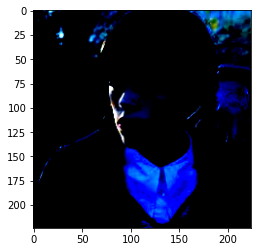

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


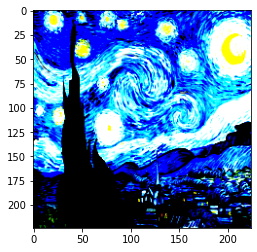

In [20]:
plt.imshow( torch.swapaxes( torch.swapaxes(content_image,0,2), 0, 1).detach().cpu().numpy() )
plt.show()
plt.imshow( torch.swapaxes( torch.swapaxes(style_image,0,2), 0, 1).detach().cpu().numpy() )
plt.show()

# Verification

In [21]:
# our vgg model , from which we will extract features

class Style_Trans(nn.Module):

    def __init__(self, model):
        
        super(Style_Trans, self).__init__()

        self.model = model # we need only upto 28 layers according to the research paper
        self.req_layers = [0, 5, 10, 19, 28, 34] 
        ''' Hyper params '''
        self.features = []
    
    def forward(self,x) :

        self.features = [] # whenever we do a forward pass , we need a empty list to store features

        for layer_num,layer in enumerate(self.model) : 
            x = layer(x)
            if layer_num in self.req_layers :
                self.features.append(x)

        return self.features # returning the features

In [22]:
# we are defining content loss here

def content_loss(gen , original):

    if len(gen) != len(original):
        print(f'something is wrong length does not match {len(original)} and {len(gen)}')
        return None

    content_loss = 0

    for i in range( len(gen) ):
        # print( (( original[i].detach() - gen[i] )**2).flatten(1,-1).mean(1).mean().shape ) # -> passed
        # ll
        # content_loss += torch.mean( ( original[i].detach() - gen[i] )**2 )
        content_loss += ( ( original[i].detach() - gen[i] )**2 ).flatten(1,-1).mean(1).mean() 

    return content_loss

In [23]:
# we are defining style loss here :

def style_loss(gen_feat , style_feat, is_features = False ):

    if len(gen_feat) != len(style_feat) :
        print(f'something is wrong length does not match {len(style_feat)} and {len(gen_feat)}')
        return None
    
    style_loss = 0
    for i in range( len(gen_feat) ):
        
        g_feat = gen_feat[i]
        g_feat = torch.flatten(g_feat ,  start_dim = -2 , end_dim = -1 )

        s_feat = style_feat[i]
        # #channel , height , width = s_feat.shape
        # s_feat = torch.flatten(s_feat , start_dim = -2 , end_dim = -1 )

        #print( torch.equal(s_feat,style_feat[i].view(channel,height*width)) )
        # raise Exception(f'test - 1 @ style loss function {s_feat.shape} ')
        if is_features :
            s_gram = torch.matmul( style_feat[i] , torch.transpose(style_feat[i], -2, -1) )

        else: s_gram =  style_feat[i]

        gen_gram = torch.matmul( g_feat , torch.transpose(g_feat, -2, -1) )

        # raise Exception(f'test - 1 @ style loss function {s_gram.shape} and {torch.equal(gen_gram.squeeze(0), g_feat.squeeze(0).mm(g_feat.squeeze(0).t()) )} ') -> passed

        # style_loss += torch.mean( ( s_gram.detach() - gen_gram )**2 )
        style_loss += ( ( s_gram.detach() - gen_gram )**2 ).flatten(-2,-1).mean(1).sum()

        #print( ( ( s_gram.detach() - gen_gram )**2 ).flatten(-2,-1).mean(1).sum().shape )  # ''' -> passed '''
        # ll

    return style_loss


In [24]:
# ('c'x'b'x'h') -> (c x bh)

In [26]:
# hyper parameters initialization :
# you can change all hyper parameters here :
n_steps = 1600
learning_rate = 5e-2
alpha = 3 # alpha for more structure
beta = 1.5 # more beta for more style
optimizer = torch.optim.Adam( [generated_img] , lr = learning_rate )

In [27]:
vgg_19 = vgg19(weights=VGG19_Weights.DEFAULT).features[:35]

for params in vgg_19.parameters():
    params.requires_grad = False

vgg_model = Style_Trans(vgg_19).eval()#.to(device)

for params in vgg_model.parameters():
    params.requires_grad = False

In [28]:
vgg19(weights=VGG19_Weights.DEFAULT)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [29]:
print(f" Number of trainable params in the model is : {sum([p.numel() for p in vgg_model.parameters() if p.requires_grad ])}")

 Number of trainable params in the model is : 0


In [30]:
def save_vgg19_img(img,path='style_transferred_img.png'):
    reverse_transforms = transforms.Compose([
        transforms.Normalize(mean=[0,0,0],std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],std=[1,1,1])
    ])
    transformed_img = reverse_transforms(img)
    save_image(transformed_img,path)

In [31]:

def transfer_style():

    content_feat = [ i.detach() for i in vgg_model(content_image)[:-2] ]
    style_feat = [ torch.flatten(s_feat,  start_dim = -2 , end_dim = -1 ).detach() for s_feat in vgg_model(style_image)[3:] ]
    style_feat = [ s_feat.mm( s_feat.t() ) for s_feat in style_feat ]

    # print( style_feat[0].shape )
    # ll

    for step in tqdm(range(n_steps)) :

        optimizer.zero_grad()
        
        #t1 = time.time()
        generator_feat = vgg_model( generated_img.unsqueeze(0) )
        #t2 = time.time()
        
        # computing loss
        c_loss = content_loss(generator_feat[:-2], content_feat)
        #t3 = time.time()
        s_loss = style_loss(generator_feat[3:], style_feat)

        #t4 = time.time()
        total_loss = beta*s_loss + alpha*c_loss
        #print(f' time taken in order (ms) : {(t2-t1)*1e3:.4f} and {(t3-t2)*1e3:.4f} and {(t4-t3)*1e3:.4f} and total time : {(t4-t1)*1e3:.4f} and'

        # updating image
        optimizer.zero_grad()
        total_loss.backward()
        #t5 = time.time()
        optimizer.step()

        #print(f' time taken in order (ms) : {(t2-t1)*1e3:.4f} and {(t3-t2)*1e3:.4f} and {(t4-t3)*1e3:.4f} and {(t5-t4)*1e3:.4f} and total time : {(t4-t1)*1e3:.4f} and')
        if (step+1) % 200 == 0 :
            print(f" Image got saved \n ")
            print(f' total loss : {total_loss} , {type(total_loss)} ')
            save_vgg19_img(generated_img.squeeze(0),'style_transfer_2.png')

In [32]:
# transfer_style()

In [33]:
# save_vgg19_img(generated_img,'sample.png')

In [34]:
'''directory = 'Style Transfered Images\celeb-1\\'

for index,filename in enumerate(os.listdir(directory)):
    f = os.path.join(directory, filename)
    img = transforms.ToTensor()(Image.open(f))
    save_vgg19_img(img,f'corrected-{index}.png') '''
    
torch.cuda.empty_cache()

### A model for NST

### Model

In [36]:
class ResBlock(nn.Module):
    # This will output image with same conv h and w
    def __init__(self, input_channels, hidden_channels, output_channels, Normalizer =  nn.BatchNorm2d , nonlinearity = nn.ReLU ):

        super(ResBlock, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels
        self.hidden_channels = hidden_channels
        self.nonlinearity = nonlinearity if nonlinearity is not None else nn.ReLU
        self.normalizer = Normalizer if Normalizer is not None else nn.BatchNorm2d
        self.pad = nn.ReflectionPad2d(1)

        self.conv_layer = nn.Sequential(

            nn.Conv2d(self.input_channels, self.hidden_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            self.normalizer(self.hidden_channels),
            self.nonlinearity(),

            # nn.ReflectionPad2d(1),

            nn.Conv2d(self.hidden_channels, self.hidden_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            self.normalizer(self.hidden_channels),
            self.nonlinearity(),

            # nn.ReflectionPad2d(1),

            nn.Conv2d(self.hidden_channels, self.output_channels, kernel_size = 3, padding = 1, stride = 1, bias = True),
            # self.normalizer(self.hidden_channels),
            self.nonlinearity(),

            # nn.ReflectionPad2d(1),

            # nn.Conv2d(self.hidden_channels, self.output_channels, kernel_size = 3, padding = 1, stride = 1, bias = False),
            # self.normalizer(self.hidden_channels),
            # self.nonlinearity(),

        )

        if self.input_channels != self.output_channels :
            self.conv_1 = nn.Conv2d(self.input_channels, self.output_channels, kernel_size = 1, padding = 0, stride = 1)

    def forward(self,x):

        Residual = x
        y = self.conv_layer(x)

        if self.input_channels != self.output_channels : Residual = self.conv_1(Residual)

        # raise Exception(f" inside condition of the res Block : {( x.shape, y.shape , torch.cat([y,Residual], 1).shape ) } Test - 1 in ResBlock ")

        return y + Residual # Residual got added here

In [37]:
class up_sample(nn.Module):
    
    def __init__(self, input_channels, output_channels, norm ):

        super(up_sample, self).__init__()
        self.norm = norm
        self.input_channels = input_channels
        self.output_channels = output_channels
        # self.hidden_channels = hidden_channels

        self.up_sampling_layer = nn.Sequential(

            nn.ConvTranspose2d(self.input_channels, self.output_channels, kernel_size = 2, stride = 2),
            nn.BatchNorm2d(self.output_channels),
            nn.ReLU(),
        )

        self.res_layer = ResBlock( self.output_channels*2 , self.output_channels, self.output_channels, Normalizer = self.norm )

    
    def forward(self, input, skip_connection):
        
        x = self.up_sampling_layer(input)
        # x = input
        # raise Exception(f" inside the up_sampling Block : {( x.shape , input.shape,  self.output_channels*2 ) } Test - 1 in up sampling block ") # 3 -> Passed

        if skip_connection is not None:
            # We need to concatenate only if skip connection is not None
            # changing image size of it is not same size as skip connection
            if x.shape[-2:] != skip_connection.shape[-2:] : 
                print(f" \n shape has been changed from {x.shape[-2:]} to this {skip_connection.shape[-2:]}") # -> test passed
                x = transforms.functional.resize(x, size = skip_connection.shape[-2:])

            y = torch.concat( [x,skip_connection] , dim = 1)
            
        else:
            y = x
        
        # raise Exception(f" inside the up_sampling Block : {( y.shape , x.shape,  self.output_channels*2 ) } Test - 1 in up sampling block ") 3 -> Passed
        '''print(f" inside the up_sampling Block (input.shape, x.shape, skip_connection.shape) : { ( input.shape , x.shape,  skip_connection.shape ) } print in up sampling block ")''' # -> test passed

        y = self.res_layer(y)
        return y


In [38]:
class style_transformer(nn.Module):

    def __init__(self,  arch = [16,32],  output_channels = 3, input_channels = 3, increase_channels = 16, norm = nn.BatchNorm2d):

        super(style_transformer, self).__init__()

        self.increase_channels = increase_channels
        self.norm = norm
        self.arch = [self.increase_channels] + arch
        self.output_channels = output_channels
        self.input_channels = input_channels

        # pooler 
        self.pooler = nn.MaxPool2d(kernel_size = 2, stride = 2)

        # Up_sampling and down_sampling module list
        self.down_sampler = nn.ModuleList()
        self.up_sampler = nn.ModuleList()

        # Input conv_layer
        self.input_conv_layer = nn.Sequential(
            
            # nn.ReflectionPad2d(1),
            # nn.Conv2d(self.input_channels, self.increase_channels, kernel_size = 3, padding = 1, stride = 1, ),
            # nn.BatchNorm2d(self.increase_channels),
            # # nn.MaxPool2d(kernel_size = 2, stride = 2),
            # nn.ReLU(),

            nn.Conv2d(self.input_channels, self.increase_channels, kernel_size = 3, padding = 1, stride = 1, ),
            nn.BatchNorm2d(self.increase_channels),
            # nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),

        )

        self.output_conv_layer = nn.Sequential(

            # nn.ConvTranspose2d(16, 32, kernel_size = 2,  stride = 2 ),
            # nn.BatchNorm2d(32),
            # nn.ReLU(),
            # nn.ReflectionPad2d(1),
            nn.Conv2d(self.increase_channels, 3, kernel_size = 3,  stride = 1, padding = 1 ),
            nn.BatchNorm2d(3),
            nn.ReLU(),

            # nn.ReflectionPad2d(1),
            nn.Conv2d(3, 3, kernel_size = 3,  stride = 1, padding = 1 ),
            # nn.ReflectionPad2d(1),
            nn.Conv2d(3, 3, kernel_size = 3,  stride = 1, padding = 1 ),
        )

        if len(self.arch) < 2 : raise Exception(' Need at-least a 2 layer arch ')


        # down_sampling portion:
        for i in range(0, len(self.arch) - 1 ):

            res_layers = self.arch[i: i+2]
            res_layers += [res_layers[-1]]
            
            # raise Exception(f" inside condition of the Down_sampler : {res_layers} Test - 1 ") # -> doubt
            ''' print( res_layers ) ''' # -> test passed

            self.down_sampler.append( ResBlock(*res_layers, Normalizer =  self.norm) )
        
        # Up_Sampling Portion
        for i,v in enumerate( reversed( range(1, len(self.arch)) )) :
            '''print( self.arch[v], self.arch[v-1] , v)''' # -> test passed
            self.up_sampler.append( up_sample(self.arch[v], self.arch[v-1], norm = self.norm) ) 
    
    def forward(self, x):
        
        x = self.input_conv_layer(x)
        ''' print(f" \n The shape after input conv layer is : {x.shape} ") ''' # -> test passed

        # storing as a skip connection
        self.skip_connections = [x]

        # pooling after input_conv
        x = self.pooler(x)

        for i,v in enumerate(self.down_sampler):
            x = v(x)
            
            if i != len(self.down_sampler) - 1 : 
                self.skip_connections.append(x)
                x = self.pooler(x)
            """print(f" shape after each down-sampling and pooling in iteration {i} : {x.shape} ")""" # -> test passed
        
        self.skip_connections = self.skip_connections[::-1]

        # checking skip connections shape
        '''for i in self.skip_connections : print(f" shape of the skip connections : {i.shape} ") ''' # -> test passed
        # ll

        for i,v in enumerate(self.up_sampler):
            '''print(x.shape)''' # -> test passed
            x = v( x, self.skip_connections[i] )
            '''print(f" shape after each up-sampling {i} : {x.shape} ")''' # -> test passed
    

        # final conv output
        x = self.output_conv_layer(x)
        ''' print(f" shape after final conv layer : {x.shape} ")  ''' # -> test passed

        return x

In [39]:
Style_Transformer_1 = style_transformer(arch = [16,32,48,64,45] )
print(f"  Number of trainable params in the model is : {sum([p.numel() for p in Style_Transformer_1.parameters() if p.requires_grad ])*1e-6:.3f} M")

  Number of trainable params in the model is : 0.595 M


In [40]:
content_image.detach().cpu().unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [41]:
Style_Transformer_1( content_image.detach().cpu().unsqueeze(0) ).shape

torch.Size([1, 3, 224, 224])

### loss fn

In [42]:
def style_content_loss(g_image_features, content_features, style_gram, alpha = 1, beta = 0.02, content_layers = -3, style_layers = 3):
        
    g_image_feat = g_image_features
    
    # computing loss
    c_loss = content_loss(g_image_feat[:content_layers], content_features)
    s_loss = style_loss(g_image_feat[style_layers:], style_gram)

    #t4 = time.time()
    total_loss = beta*s_loss + alpha*c_loss

    return total_loss, (beta*s_loss).item(), (alpha*c_loss).item()

### DataLoader

In [43]:
content_image_transforms = transforms.Compose([
    
        transforms.Resize( (224,224) ),
        # transforms.RandomCrop(size = (12,12) ),
        transforms.RandomAffine(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

In [44]:
class content_image_loader(Dataset):

    def __init__(self, path = 'All Content Image\collected_images\\' , transformations = content_image_transforms ):

        self.root = path
        self.image_list = os.listdir(path)
        self.transformations = transformations
    
    def __len__(self):
        return int( len(self.image_list) )
    
    def __getitem__(self,index):

        img_path =  self.image_list[index]

        # getting the paths 
        total_img_path = os.path.join( self.root, img_path )

        # getting the image
        image = Image.open( total_img_path ).convert('RGB')

        # doing transformations if any of them is there
        if self.transformations:
            image = self.transformations(image)

        # print(f' image shape : {image.shape} and mask shape : {mask.shape} ')
        return image


In [45]:
content_dataset =  content_image_loader()
# content_dataloader = DataLoader(content_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

### Trainer

In [46]:
class Style_Trainer():

    def __init__(self, name, model, optimizer, train_dataloader, optimizer_params, style_img, feature_model ):

        # initializing models
        self.name = name
        self.model = model.to(device)

        print(self.model)

        # training data
        self.train_dataloader = train_dataloader

        # optimizers and loss fn
        self.optimizer_1 = optimizer(self.model.parameters(), **optimizer_params)
        # self.optimizer = StepLR(self.optimizer_1, step_size=5, gamma=5e-3)
        self.loss = style_content_loss

        # style image gram matrix
        self.style_img = style_img.to(device)
        self.feature_model = feature_model.to(device)

        # feature_maps of style image and style gram
        self.style_feature = self.feature_model(self.style_img)
        self.style_feat = [ torch.flatten(s_feat,  start_dim = -2 , end_dim = -1 ).detach() for s_feat in self.style_feature[3:] ]
        self.style_gram = [ s_feat.mm( s_feat.t() ).unsqueeze(0) for s_feat in self.style_feat ]
        # print(self.style_gram[0].shape)
        # jj
    
    def train_model(self, epochs = 10, print_freq = 1, save_freq = 1, alpha = 1, beta = 0.02):

        style_loss = []
        content_loss = []

        # val_loss = []
        # val_metric = []

        # with torch.cuda.amp.autocast():

        if epochs > 0:

            for e in range(epochs):

                epoch_s_loss = 0
                epoch_c_loss = 0
                total_images = 0

                loop_obj = tqdm( enumerate(self.train_dataloader), total = len(self.train_dataloader), desc = 'train epoch progress' )

                for index,batch in loop_obj:

                    image = batch

                    # zero_grad optimizer to erase previous gradients
                    self.optimizer_1.zero_grad()

                    # changing type and data type of the image to ensure computability
                    image = image.to(device).type(torch.float32)

                    # getting the prediction from the model
                    generated = self.model(image)

                    # getting the feature maps of the generated and content img
                    generated_features = self.feature_model(generated)
                    content_features = self.feature_model(image)[:-3]

                    # calculating loss:
                    total_loss, s_loss, c_loss = self.loss(generated_features, content_features, self.style_gram, alpha = alpha, beta = beta)

                    # raise Exception(f" Checking the size of the loss : {Loss} ")
                    loop_obj.set_description(f" s_loss : {s_loss} ; c_loss : {c_loss}", refresh = True)

                    # print(total_loss)
                    # ll

                    # updating weights
                    total_loss.backward()
                    self.optimizer_1.step()
                    # self.optimizer.step()

                    # calculating loss
                    epoch_s_loss += s_loss*len(image)
                    epoch_c_loss += c_loss*len(image)

                    # total_images_count
                    total_images += len(image)
                
                # Now storing the Loss and metric of every epoch
                style_loss.append( epoch_s_loss/total_images )
                content_loss.append( epoch_c_loss/total_images )

                # # Now storing the value of val loss and val metric
                # validation_data = self.eval()

                # # Now storing them in the validation history
                # val_loss.append(validation_data[0])
                # val_metric.append(validation_data[1])

                if (e+1) % print_freq == 0  :

                    print(f"\n=====================================================")
                    print(f" The current epoch is : {e+1}")
                    print(f" Style Loss is : {style_loss[-1]:.3f}")
                    print(f" Content Loss is : {content_loss[-1]:.3f}")
                    print(f"=====================================================\n")
                    
                    if not os.path.exists(f'img\model_images\\{self.name}\\') : os.mkdir(f'img\model_images\\{self.name}\\')
                    # img_path = np.random.choice( os.listdir(f'All Content Image\collected_images'), size = 1)
                    example_content_image = load_image(path=f"Celeb-images\wednesday-thinking.jfif", size = (512,512) ).to(device)
                    generated_style_img = self.model( example_content_image.unsqueeze(0) ).detach().cpu()
                    save_vgg19_img(generated_style_img.squeeze(0),f'img\model_images\\{self.name}\\{e}.png')
                    
                
                if (e+1) % save_freq == 0  :
                    path = f'models/saved_models/{self.name}/'

                    if os.path.exists(path) : torch.save(self.model.state_dict(), f'models/saved_models/{self.name}/epoch_{e}.pt')
                    
                    else:
                        os.mkdir(path)
                        torch.save(self.model.state_dict(), f'models/saved_models/{self.name}/epoch_{e}.pt')
             
        return [style_loss, content_loss]

### Training model

#### Hyper params

In [47]:
from torch.optim.lr_scheduler import StepLR

In [48]:
# Hyper params 

lr = 5e-4
epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2

optimizer = torch.optim.Adam
optimizer_params = {'lr' : lr,}

alpha = 5
beta = 5*1e-6

In [49]:
content_dataloader = DataLoader(content_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

In [50]:
arch1 = [16,32,64,128,128,256]
arch2 = [64,128,256,512]
arch3 = [16,32,64,128,256]
arch4 = [16,64,128,256,512]

Style_Model_1 = style_transformer(arch = arch1, norm = nn.BatchNorm2d ).to(device)
print(f"  Number of trainable params in the model is : {sum([p.numel() for p in Style_Model_1.parameters() if p.requires_grad ])*1e-6:.3f} M")

Style_Model_1.load_state_dict( torch.load('models\saved_models\style_30\epoch_59.pt', map_location=device), strict = True )

  Number of trainable params in the model is : 4.159 M


<All keys matched successfully>

In [ ]:
# print(*list(Style_Model_1.state_dict().keys()), sep='\n')

In [214]:
# k = torch.load('models\saved_models\style_20\epoch_59.pt', map_location=device)
# # print(*list(k.keys()),sep='\n')

# for v in k:
#     print(v,'\t',k[v].shape)

In [51]:
# style img
style_img_9 = load_image( path = 'style images\style38.png', size = (224,224) )

# vgg based feature extractor
for params in vgg_19.parameters():
    params.requires_grad = False

feature_extractor_model = Style_Trans(vgg_19).to(device).eval()

for params in feature_extractor_model.parameters():
    params.requires_grad = False

#### Training

In [52]:
Trainer = Style_Trainer(name = 'style_38', model = Style_Model_1, optimizer = optimizer, train_dataloader = content_dataloader, 
                        optimizer_params = optimizer_params, style_img = style_img_9, feature_model = feature_extractor_model )

style_transformer(
  (pooler): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_sampler): ModuleList(
    (0): ResBlock(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv_layer): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU()
      )
    )
    (1): ResBlock(
      (pad): ReflectionPad2d((1, 1, 1, 1))
      (conv_layer): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
loss_history = Trainer.train_model( epochs = 300, print_freq = 10, save_freq = 15, alpha=alpha, beta=beta)

In [53]:
torch.cuda.empty_cache()

torch.Size([512, 512])
torch.Size([3, 512, 512]) torch.Size([3, 512, 512]) torch.Size([512, 512])
torch.Size([3, 512, 512])


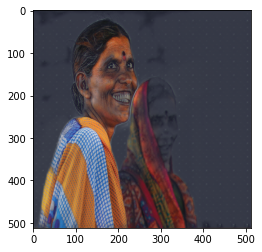

In [63]:
# example content_image
selective_style = True

for i in os.listdir('All Content Image\collected_images')[20:21]:

    example_content_image = load_image(path=f"All Content Image\collected_images\{i}", size = (512,512) ).to(device)
    generated_style_img = Style_Model_1.eval()( example_content_image.unsqueeze(0) ).detach().cpu()

    # applying selective style
    if selective_style :
        original_image = Image.open(f"All Content Image\collected_images\{i}").convert('RGB')
        selective_style_transferred = image_imposition(original_image,generated_style_img,['Background'],size = (512,512), show = True)

    save_vgg19_img(generated_style_img.squeeze(0),f'Style Transfered Images\collected_images_style_transferred\{i.split(".")[0]}.png')
    save_vgg19_img(selective_style_transferred.squeeze(0),f'Style Transfered Images\selective_style_transfer\{i.split(".")[0]}.png' )

In [ ]:
example_content_image = load_image(path=f"All Content Image\collected_images\indian-dresses-slide.jpg", size = (720,720) ).to(device)
generated_style_img = Style_Model_1( example_content_image.unsqueeze(0) ).detach().cpu()

save_vgg19_img(generated_style_img.squeeze(0),f'style_transfer_2.png')

In [ ]:
torch.cuda.empty_cache()

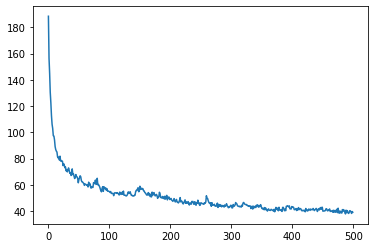

In [ ]:
plt.plot( loss_history[0] )

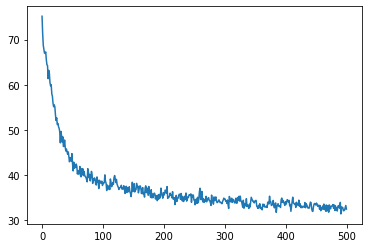

In [ ]:
plt.plot( loss_history[1] )

In [ ]:
loss_history[0].index( min(loss_history[0]) )

487

In [ ]:
fire_model = torch.load('models\saved_models\style_37\epoch_359.pt', map_location=device)
fire_keys = fire_model.keys()

In [ ]:
for i,v in zip(fire_model.values(),fire_model.keys()):
    print(v," \t " ,i.shape)

down_sampler.0.conv_layer.0.weight  	  torch.Size([64, 16, 1, 1])
down_sampler.0.conv_layer.1.weight  	  torch.Size([64])
down_sampler.0.conv_layer.1.bias  	  torch.Size([64])
down_sampler.0.conv_layer.1.running_mean  	  torch.Size([64])
down_sampler.0.conv_layer.1.running_var  	  torch.Size([64])
down_sampler.0.conv_layer.1.num_batches_tracked  	  torch.Size([])
down_sampler.0.conv_layer.3.weight  	  torch.Size([64, 64, 3, 3])
down_sampler.0.conv_layer.4.weight  	  torch.Size([64])
down_sampler.0.conv_layer.4.bias  	  torch.Size([64])
down_sampler.0.conv_layer.4.running_mean  	  torch.Size([64])
down_sampler.0.conv_layer.4.running_var  	  torch.Size([64])
down_sampler.0.conv_layer.4.num_batches_tracked  	  torch.Size([])
down_sampler.0.conv_layer.6.weight  	  torch.Size([64, 64, 3, 3])
down_sampler.0.conv_layer.7.weight  	  torch.Size([64])
down_sampler.0.conv_layer.7.bias  	  torch.Size([64])
down_sampler.0.conv_layer.7.running_mean  	  torch.Size([64])
down_sampler.0.conv_layer.7.ru